# Basic plots
Author: Daheng Wang  
Last modified: 2017-05-28

# Road map
1. Basic tweet related plots
2. Basic user related plots

# Steps

In [2]:
"""
Initialization
"""

'''
Data analysis modules: pandas, matplotlib, numpy, and etc
'''
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # render double resolution plot output for Retina screens 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

'''
Standard modules, MongoDB modules
''' 
import os, sys, json, datetime, pickle
from pprint import pprint
import pymongo
from pymongo import IndexModel, ASCENDING, DESCENDING

'''
Custom tool modules
'''
import mongodb  # module for setting up connection with (local) MongoDB database
import multiprocessing_workers  # module for splitting workloads between processes
import utilities  # module for various custom utility functions
from config import *

"""
Misc
"""
NB_NAME = '20170424-basic_plots'
# ISO8601_FMT = '%Y-%m-%dT%H:%M:%S.%fZ' # default datetime string format

## Basic tweet related plots

### Tweet number agst. datetime

In [6]:
"""
Make pickle for figure
"""

tw_collection_speed_dict_pkl = os.path.join(TMP_DIR, '{}-{}'.format(NB_NAME, 'tw_collection_speed.dict.pkl'))

if 0 == 1:
    print("Making pickle from database...")
    
    data_dict = {} # dictiionary of data in format of {'id': 'created_at'}
    tw_raw_pct_col = mongodb.initialize(db_name=DB_NAME, collection_name=TW_RAW_PCT_COL)
    cursor = tw_raw_pct_col.find(projection={'_id': 0, 'id': 1, 'X_creation': 1})
    
    for doc in cursor:
        id_int = int(doc['id'])
        creation_obj = doc['X_creation']
        #created_at_obj = datetime.datetime.strptime(created_at_str, iso8601_fmt)
        
        data_dict[id_int] = creation_obj
    with open(tw_collection_speed_per_hour_dict_pkl, 'wb') as f:
        pickle.dump(data_dict, f)
    print('Done')

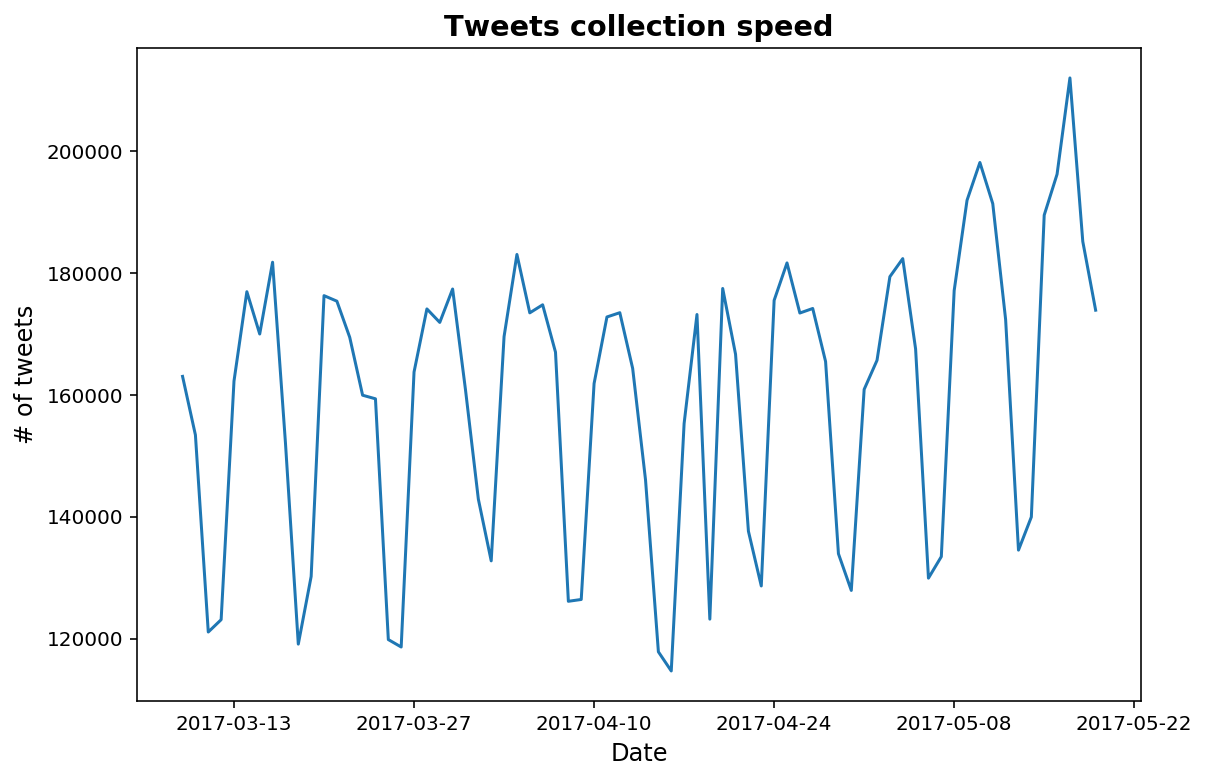

In [13]:
"""
Plot the number of tweets collected on daily basis
"""

tw_collection_speed_fig = os.path.join(FIG_DIR, 'tw_collection_speed.png')

if 1 == 1:
    '''
    Prepare data
    '''
    data_dict = {} # dictiionary of data in format of {'id': 'created_at'}
    with open(tw_collection_speed_dict_pkl, 'rb') as f:
        data_dict = pickle.load(f)
    
    # build DatetimeIndex
    dt_ind = pd.to_datetime(list(data_dict.values()), utc=True) # only timestamp information needed here for plotting
    
    ts = pd.Series(data=np.ones_like(dt_ind, dtype=int), # fill 'num' column with 1
                   index=dt_ind,
                   dtype=int,
                   name='num')

    # resample DatetimeIndex hourly/daily
    ts_new = ts.resample(rule='1d').sum()
    
    '''
    Plot
    '''
    fig, ax = plt.subplots(figsize=(9, 6))
    
    plt.plot(ts_new[1:-1]) # exclue the first and last day from plotting
    
    title_fontdict = {'weight': 'bold', 'size': 'x-large'}
    ax.set_title('Tweets collection speed', fontdict=title_fontdict)
    
    label_fontdict = {'size': 'large'}
    ax.set_xlabel('Date', fontdict=label_fontdict)
    ax.set_ylabel('# of tweets', fontdict=label_fontdict )

    '''
    Save figure
    '''
    plt.savefig(tw_collection_speed_fig, dpi=200)

## LEGACY Basic user related plots

### followers_count/friends_count against user's rank

In [16]:
followers_and_friends_count_pkl = os.path.join(TMP_DIR,'followers_and_friends_count.pkl')
followers_count_fig = os.path.join(FIG_DIR, 'followers_count.png')
friends_count_fig = os.path.join(FIG_DIR, 'friends_count.png')

_Step 1_ Check if pickle data exist. If no, query tweets ('id', 'followers_count') from database, and pickle into local file.

In [17]:
if not os.path.exists(followers_and_friends_count_pkl):
    print("Building pickle from database...")
    # list of dictionaries in format {'id': int, 'followers_count': int, 'friends_count': int}
    data_lst = []

    user_col = mongodb.initialize(db_name=DB_NAME, collection_name=USERS_COL)
    cursor = user_col.find(projection={
        '_id': 0,
        'id': 1,
        'followers_count': 1,
        'friends_count': 1
    })
    for doc in cursor:
        data_lst.append(dict(doc))

    with open(followers_and_friends_count_pkl, 'wb') as f:
        pickle.dump(data_lst, f)
    print('Done')
else:
    print('Pickled data found')

Pickled data found


_Step 2_ Load pickled data into dataframe and plot

In [18]:
if 0 == 1:
    data_lst = [] # dictiionary of data in format of {'id': 'followers_count'}
    if not data_lst: # load data from pickle
        with open(followers_and_friends_count_pkl, 'rb') as f:
            data_lst = pickle.load(f)
    
    df = pd.DataFrame(data=data_lst,
                      columns=['id', 'followers_count', 'friends_count'],
                      dtype=int)
    df = df.set_index('id')
    
    # compute user's rank information by 'followers_count' and 'friends_count'
    df['followers_count_rank'] = df['followers_count'].rank(method='first', ascending=False)
    df['friends_count_rank'] = df['friends_count'].rank(method='first', ascending=False)

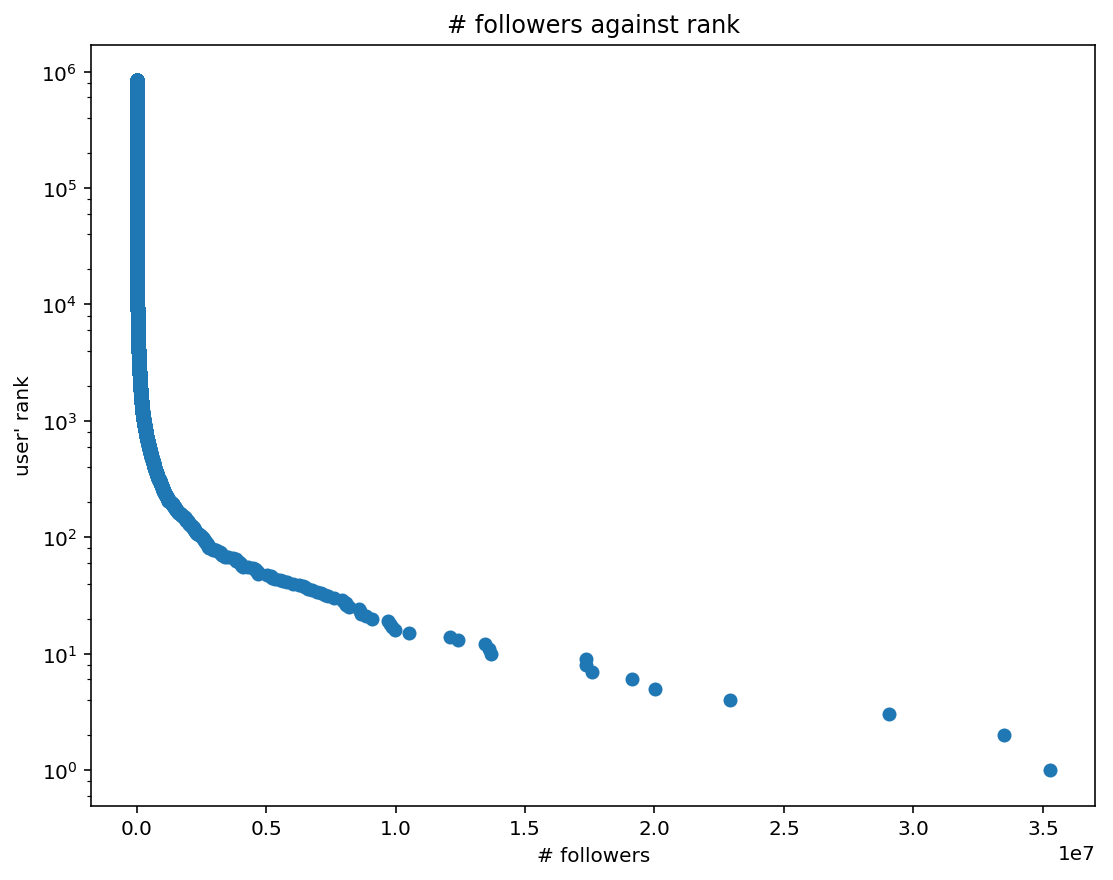

In [53]:
if 0 == 1:
    # plot and save figure   
    plt.figure(figsize=(9,7))
    plt.title('# followers against rank')
    plt.xlabel('# followers')
    plt.ylabel('user\' rank')
    plt.yscale('log')
    plt.scatter(x = df['followers_count'], y = df['followers_count_rank'])
    plt.savefig(followers_count_fig)

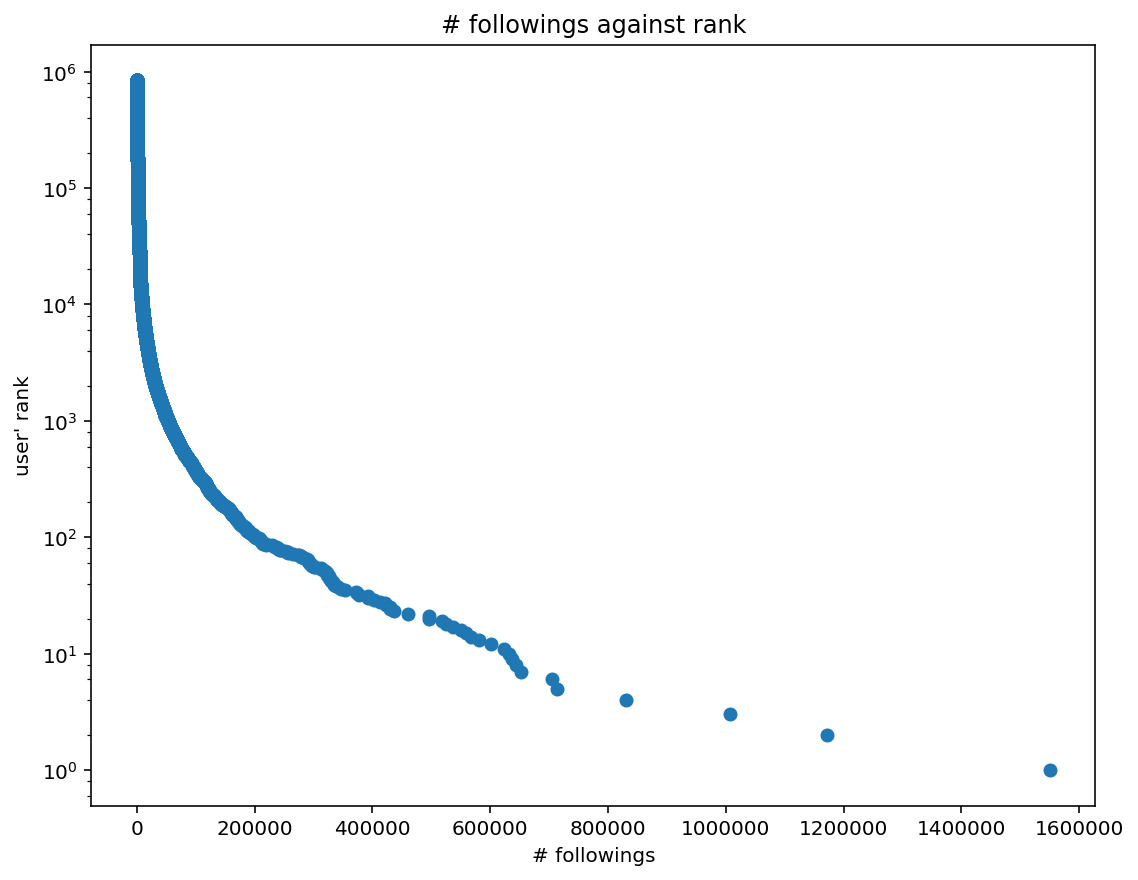

In [54]:
if 0 == 1:
    # plot and save figure   
    plt.figure(figsize=(9,7))
    plt.title('# followings against rank')
    plt.xlabel('# followings')
    plt.ylabel('user\' rank')
    plt.yscale('log')
    plt.scatter(x = df['friends_count'], y = df['friends_count_rank'])
    plt.savefig(friends_count_fig)